# Tutorial: Training a Model

Author: Vignesh Sathyaseelan (vsathyas@purdue.edu)

In this tutorial, we will walk step by step through the process of training a MACE model.

### Learning Objectives
- Understand how to load and explore data
- Learn preprocessing steps before model training
- Train MACE model and evaluate its performance
- Visualize results and make predictions


## 1. Import Dependencies


In [14]:
# Install the Atomic Simulation Environment (ASE)
# for atomistic simulations, geometry optimization, NEB, etc.
!pip install ase

# Install MACE (Machine-learning for Atomistic Computations) with PyTorch backend
# Provides ML interatomic potentials, compatible with ASE
!pip install mace-torch

# Install DFT-D3 (dispersion correction code)
# Useful for adding Grimme's D3 dispersion corrections to DFT/ML calculations
!pip install torch-dftd

## 2. Load the Dataset

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# ---------------------
# 1. Load training data from xTB
# ---------------------
db = read("/content/drive/MyDrive/Colab Notebooks/data/solvent_xtb_train_small.xyz", ":")  # your xtb dataset (energies + forces)

# ---------------------
# 2. Train a MACE model on xTB data
# ---------------------
# Simplified training call (details depend on MACE version)
from mace.cli.run_train import main as mace_run_train_main
import sys

 High-level explanation of the important parameters in MACE.

- ##### <font color='red'>--num_interactions</font>: message-passing layers

Controls the number of message-passing layers in the model.

- ##### <font color='red'>--hidden_irreps</font>: number of message passing layers

Determines the size of the model and its symmetry.
For example: `hidden_irreps='128x0e'` means the model has `128` channels or paths, the output is invariant under rotation ($L_{\rm max}=0$) and even under inversion (`'e'`). For most applications, these settings will do well. `hidden_irreps='64x0e + 64x1o'` means the model has `64` channels and is equivariant under rotation ($L_{\rm max}=0$).

Alternatively, the model size can be adjusted using a pair of more user-friendly arguments:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font color='red'>--num_channels=32</font>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font color='red'>--max_L=2</font>

which, taken together achieve the same as <font color='red'>--hidden_irreps='32x0e + 32x1o + 32x2e'</font>
    
<font color='blue'>**In general, the `accuracy` of the model can be improved by using more layers, more channels or higher equivariances. This will result in more parameters and `slower` models.**</font>

- ##### <font color='red'>--correlation</font>: the order of the many-body expansion
$$
E_{i} = E^{(0)}_{i} + \sum_{j} E_{ij}^{(1)} + \sum_{jk} E_{ijk}^{(2)} + ...
$$

The energy-expansion order that MACE induces at each layer. Choosing `--correlation=3` will create basis functions of up to 4-body (ijkl) indices, for each layer. If the model has multiple layers, the effective correlation order is higher. For example, a two-layer MACE with `--correlation=3` has an effective body order of `13`.

- ##### <font color='red'>--r_max</font>: the cutoff radius

The cut-off applied to local environment in each layer. `r_max=3.0` means atoms separated by a distance of more than 3.0 A do not directly `communicate`. When the model has multiple message-passing layers, atoms further than 3.0 A can still `communicate` through later messages if intermediate proxy atoms exist. The effective `receptive field` of the model is `num_interactions x r_max`.

- ##### <font color='red'>--max_ell</font>: angular resolution

The angular resolution describes how well the model can describe angles. This is controlled by `l_max` of the spherical harmonics basis (not to be confused with `L_max`). Larger values will result in more accurate but slower models. The default is `l_max=3`, appropriate in most cases.

Let's train our first model:
- ##### <font color='red'>--name</font>: the name of the model
This name will be used to form file names (model, log, checkpoints, results), so choose a distinct name for each experiment

- ##### <font color='red'>--model_dir, --log_dir, --checkpoints_dir, --results_dir</font>: directory paths
These are the directories where each type of file is saved. For simplicity, we will all files in the same directory.

- ##### <font color='red'>--train_file</font>: name of training data

These data configs are used to compute gradients and update model parameters.

- ##### <font color='red'>--valid_file</font>: name of validation data
An alternative way to choose the validation set is by using the `--valid_fraction` keyword. These data configs are used to estimate the model accuracy during training, but not for parameter optimization. The validation set also controls the stopping of the training. At each `--eval_interval` the model is tested on the validation set. The evaluation of these configs takes place in batches, which can be controlled by `--valid_batch_size`. If the accuracy of the model stops improving on the validation set for `--patience` number of epochs, the model will undergo **early stopping**.

- ##### <font color='red'>--test_file</font>: name of testing data

This set is entirely independent and only gets evaluated at the end of the training process to estimate the model accuracy on an independent set.

- ##### <font color='red'>--E0s</font>: isolated atom energies

Controls how `E0s` should be determined. The strongly recommended approach is to add these values to the training set with `config_type=IsolatedAtom` in `atoms.info` and set `E0s="isolated"`. If these values are not available, MACE can estimate them by least square regression over the available data `E0s="average"` which can lead to unintended consequences depending on how representative the data is.

- ##### <font color='red'>--energy_key, --forces_key</font> the key where these values are stores
This key must coincide with the `ase.Atoms.info[key]/ase.Atoms.arrays[key]` where the energies and forces are stored in the ase.Atoms object.

- ##### <font color='red'>--device</font> computing device to use
Can be CPU (`cpu`), GPU (`cuda`) or Apple Silicon (`mps`). Here we will use `cuda` since the GPU will be significantly faster than the CPU.

- ##### <font color='red'>--batch_size</font> number of configs evaluated in one batch
Number of configs used to compute the gradients for each full update of the network parameters. This training strategy is called stochastic gradient descent because only a subset of the data (`batch_size`) is used to change the parameters at each update.

- ##### <font color='red'>--max_num_epochs</font> number of passes through the data
An `epoch` is completed when the entire training data has been used once in updating the weights `batch` by `batch`. A new epoch begins, and the process repeats.

- ##### <font color='red'>--swa</font> protocol for loss weights
During training you will notice energy errors are at first much higher than force errors, MACE implements a special protocol that increases the weight on the energy in the loss function (`--swa_energy_weight`) once the forces are sufficiently accurate. The starting epoch for this special protocol can be controlled by changing `--start_swa`.

- ##### <font color='red'>--seed</font> random number generator seed
Useful for preparing committee of models.

## 3. Define the Model

Here we define the model architecture or algorithm that we want to train.

In [17]:
%%writefile config.yml

model: "MACE"
num_channels: 16
max_L: 1
r_max: 4.0
name: "mace01"
model_dir: "MACE_models"
log_dir: "MACE_models"
checkpoints_dir: "MACE_models"
results_dir: "MACE_models"
train_file: "/content/drive/MyDrive/Colab Notebooks/data/solvent_xtb_train_small.xyz"
valid_fraction: 0.10
test_file: "/content/drive/MyDrive/Colab Notebooks/data/solvent_xtb_test.xyz"
energy_key: "energy_xtb"
forces_key: "forces_xtb"
device: cpu
batch_size: 10
max_num_epochs: 10
swa: True
seed: 123

Overwriting config.yml


## 4. Train the Model


In [18]:
import warnings
warnings.filterwarnings("ignore")
from mace.cli.run_train import main as mace_run_train_main
import sys
import logging

def train_mace(config_file_path):
    logging.getLogger().handlers.clear()
    sys.argv = ["program", "--config", config_file_path]
    mace_run_train_main()

train_mace("config.yml")

2025-09-23 17:55:54.147 INFO: ===========VERIFYING SETTINGS===========
2025-09-23 17:55:54.148 INFO: MACE version: 0.3.14
2025-09-23 17:55:54.150 INFO: Using CPU
2025-09-23 17:55:54.154 INFO: ===========LOADING INPUT DATA===========
2025-09-23 17:55:54.157 INFO: Using heads: ['Default']
2025-09-23 17:55:54.159 INFO: Using the key specifications to parse data:
2025-09-23 17:55:54.161 INFO: Default: KeySpecification(info_keys={'energy': 'energy_xtb', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head', 'elec_temp': 'elec_temp', 'total_charge': 'total_charge', 'polarizability': 'polarizability', 'total_spin': 'total_spin'}, arrays_keys={'forces': 'forces_xtb', 'charges': 'REF_charges'})
2025-09-23 17:55:54.162 INFO: =============    Processing head Default     ===========
2025-09-23 17:55:54.355 INFO: Using isolated atom energies from training file
2025-09-23 17:55:54.370 INFO: Training set 1/1 [energy: 200, stress: 0, virials: 0, dipole components: 0, hea

In [19]:
from mace.cli.eval_configs import main as mace_eval_configs_main
import sys

def eval_mace(configs, model, output):
    sys.argv = ["program", "--configs", configs, "--model", model, "--output", output]
    mace_eval_configs_main()

#evaluate the training set
eval_mace(configs="/content/drive/MyDrive/Colab Notebooks/data/solvent_xtb_eval_200.xyz",
          model="MACE_models/mace01_run-123_stagetwo.model",
          output="/content/drive/MyDrive/Colab Notebooks/data/solvent_mace_eval_200.xyz")

2025-09-23 18:46:27.039 INFO: Using CPU


## 6. Evaluate the Model

Energy RMSE (eV): 6.050571672188669
Energy MAE  (eV): 4.0163141463829675
Force RMSE  (eV/Å): 1.6748032073098331
Force MAE   (eV/Å): 1.0204994719056637


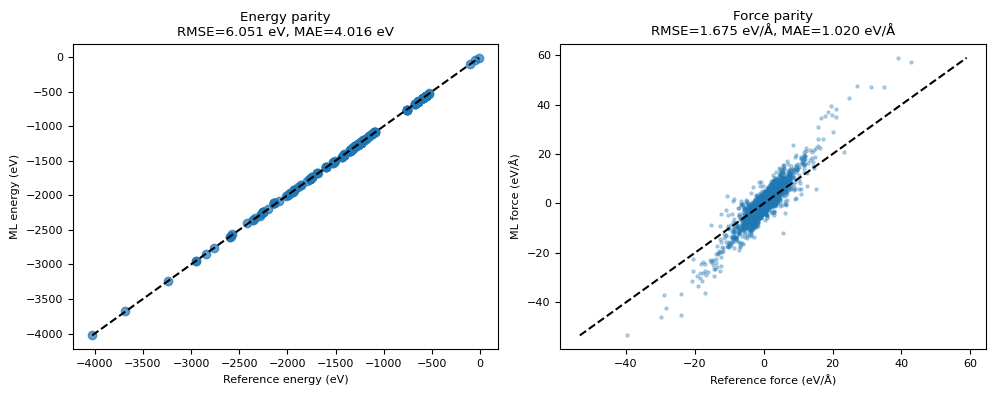

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read
from sklearn.metrics import mean_squared_error, mean_absolute_error

# -------------------------
# Load data
# -------------------------
ref_db = read("/content/drive/MyDrive/Colab Notebooks/data/solvent_xtb_eval_200.xyz", ":")   # ground truth
ml_db  = read("/content/drive/MyDrive/Colab Notebooks/data/solvent_mace_eval_200.xyz", ":")            # ML predictions

assert len(ref_db) == len(ml_db), "Databases must have same number of configs"

# -------------------------
# Collect energies
# -------------------------
energies_ref = np.array([at.info["energy_xtb"] for at in ref_db])
energies_ml  = np.array([at.info["MACE_energy"] for at in ml_db])  # change key if different

# -------------------------
# Collect forces
# -------------------------
forces_ref = np.concatenate([at.arrays["forces_xtb"] for at in ref_db])
forces_ml  = np.concatenate([at.arrays["MACE_forces"] for at in ml_db])

# -------------------------
# Compute errors
# -------------------------
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

energy_rmse = rmse(energies_ref, energies_ml)
energy_mae  = mean_absolute_error(energies_ref, energies_ml)

force_rmse  = rmse(forces_ref.flatten(), forces_ml.flatten())
force_mae   = mean_absolute_error(forces_ref.flatten(), forces_ml.flatten())

print("Energy RMSE (eV):", energy_rmse)
print("Energy MAE  (eV):", energy_mae)
print("Force RMSE  (eV/Å):", force_rmse)
print("Force MAE   (eV/Å):", force_mae)

# -------------------------
# Parity plots
# -------------------------
plt.figure(figsize=(10,4))

# Energies
plt.subplot(1,2,1)
plt.scatter(energies_ref, energies_ml, alpha=0.7)
lims = [min(energies_ref.min(), energies_ml.min()), max(energies_ref.max(), energies_ml.max())]
plt.plot(lims, lims, "k--")
plt.xlabel("Reference energy (eV)")
plt.ylabel("ML energy (eV)")
plt.title(f"Energy parity\nRMSE={energy_rmse:.3f} eV, MAE={energy_mae:.3f} eV")

# Forces
plt.subplot(1,2,2)
plt.scatter(forces_ref.flatten(), forces_ml.flatten(), alpha=0.3, s=5)
lims = [min(forces_ref.min(), forces_ml.min()), max(forces_ref.max(), forces_ml.max())]
plt.plot(lims, lims, "k--")
plt.xlabel("Reference force (eV/Å)")
plt.ylabel("ML force (eV/Å)")
plt.title(f"Force parity\nRMSE={force_rmse:.3f} eV/Å, MAE={force_mae:.3f} eV/Å")

plt.tight_layout()
plt.show()